<a href="https://colab.research.google.com/github/goncalobv/ml-experiments/blob/main/Interpretability_Activation_maximization_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# The experiments below might reuse some code from the MIT course on Introduction to Deep Learning, released uder the MIT license:

# Copyright 2021 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved.
# 
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of 6.S191 must
# reference:
#
# © MIT 6.S191: Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Activation maximization on MNIST dataset
In this notebook, we modify code from one of the labs in [Intro to Deep Learning](http://introtodeeplearning.com/) to apply Activation Maximization (AM) from tf-keras-vis.

We follow a similar approach as shown in the [Machine Curve blog](https://www.machinecurve.com/index.php/2019/11/18/visualizing-keras-model-inputs-with-activation-maximization/) and the
[tf-keras-vis dense layer](https://github.com/keisen/tf-keras-vis/blob/ddd951396f16e7f5b7a0e8619f43f99c599628fb/examples/visualize_dense_layer.ipynb) example.

Note that AM generates an input image that maximizes the output class. The activation images represent what the network learnt, which might not match closely the input images.

After generating the activation images, we confirm that these indeed maximize activation of the output neurons.

In [ ]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

!pip install mitdeeplearning
!pip install tf-keras-vis


import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.float32)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.float32)

nr_classes = 10

train_labels_cat = tf.keras.utils.to_categorical(train_labels, nr_classes)
test_labels_cat = tf.keras.utils.to_categorical(test_labels, nr_classes)

In [ ]:
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.callbacks import Print
from tf_keras_vis.utils.input_modifiers import Jitter, Rotate
from tf_keras_vis.utils.regularizers import L2Norm, TotalVariation
from tf_keras_vis.utils.callbacks import OptimizerCallback

class print_activations(OptimizerCallback):  
  def __init__(self, interval):
    self.interval = interval
    
  def __call__(self, i, values, grads, losses, model_outpus, **kwargs):
    if (i+1) % self.interval == 0:
      print('Iteration ', i+1)
      printActivationImages(activations=values)

def AM_MNIST(model, output_indexes, steps=1000, learning_rate=.01, jitter=.02, rotate=1., tv=.01, l2norm=.02, rho=.95):
  def loss(output):
    #print(output)
    # For seed input i, maximize prediction of class output j
    return [output[i, j] for (i,j) in enumerate(output_indexes)]

  def model_modifier(m):
      m.layers[-1].activation = tf.keras.activations.linear

  # Initialize Activation Maximization
  visualize_activation = ActivationMaximization(model, model_modifier)

  # Generate a random seed for each activation
  seed_input = tf.random.uniform((len(output_indexes), 28, 28, 1), 0, 1)

  # Generate activations and convert into images
  activations = visualize_activation(loss,
                                     seed_input=seed_input, 
                                     input_range=(0,1.),
                                     input_modifiers=[Jitter(jitter), Rotate(rotate)], #
                                     regularizers=[TotalVariation(tv), L2Norm(l2norm)], #
                                     steps=steps, 
                                     optimizer=tf.optimizers.RMSprop(learning_rate, rho),
                                     callbacks=[Print(interval=50)], # print_activations(interval=50)
                                     )

  return activations


def printActivationImages(activations):
  if len(activations) == 1:
    activations = activations[0]
  images = [activation.astype(np.float32) for activation in activations]

  # Visualize each image
  #f, ax = plt.subplots(1, len(images))
  for i in range(0, len(images)):
    plt.imshow(images[i].reshape(28,28))
    plt.title(f'MNIST target = {i}')
    plt.show()


## Training 3 neural networks on MNIST
We propose 3 neural networks to train on the MNIST dataset:

(i) Simple dense fully connected network with a single hidden layer

(ii) Simple Convolutional Neural Network (CNN) with 1 convolution layer + 1 hidden fully connected layer

(iii) CNN with 2 convolution layers + 1 hidden fully connected layer

In [ ]:
# Define a very simple fully connected model
def build_fc_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

# CNN as presented in the Intro to Deep Learning lab
def build_cnn_model():
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=24, kernel_size=3, activation='relu'), 
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.Conv2D(filters=36, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    return cnn_model
# Simpler CNN matching https://github.com/keisen/tf-keras-vis/blob/master/examples/visualize_dense_layer.ipynb
def build_simple_cnn_model():
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'), 
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    return cnn_model

  
model = build_fc_model()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy']) # TODO

model.fit(train_images, train_labels_cat, batch_size=128, epochs=25, validation_split = 0.2, verbose=1)

test_loss, test_acc = model.evaluate(test_images, test_labels_cat)

print('Test accuracy:', test_acc)

Epoch 1/25
375/375 [==============================] - 2s 4ms/step - loss: 0.6741 - accuracy: 0.8152 - val_loss: 0.2060 - val_accuracy: 0.9438
Epoch 2/25
375/375 [==============================] - 1s 3ms/step - loss: 0.1893 - accuracy: 0.9448 - val_loss: 0.1575 - val_accuracy: 0.9557
Epoch 3/25
375/375 [==============================] - 1s 3ms/step - loss: 0.1371 - accuracy: 0.9610 - val_loss: 0.1314 - val_accuracy: 0.9613
Epoch 4/25
375/375 [==============================] - 1s 3ms/step - loss: 0.1069 - accuracy: 0.9698 - val_loss: 0.1130 - val_accuracy: 0.9675
Epoch 5/25
375/375 [==============================] - 1s 4ms/step - loss: 0.0823 - accuracy: 0.9762 - val_loss: 0.1065 - val_accuracy: 0.9687
Epoch 6/25
375/375 [==============================] - 1s 4ms/step - loss: 0.0665 - accuracy: 0.9825 - val_loss: 0.0971 - val_accuracy: 0.9706
Epoch 7/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0580 - accuracy: 0.9840 - val_loss: 0.0952 - val_accuracy: 0.9713
Epoch 

The activation images should correspond to input images that maximize the activation of the output nodes, one image for each class. For simpler networks (especially (i) the fully connected single hidden layer), the activation images don't closely match input images, meaning the network learnt a different internal representation from what we wanted.

In order to test that the activation images mazimize activation of the output class, we pass the activation images through the network and show their class probability.

Steps: 050	Losses: [[460.00518798828125, 439.58966064453125, 777.0869140625, 707.6158447265625, 655.5316162109375, 769.3419189453125, 677.5971069335938, 814.46142578125, 337.8890686035156, 721.7670288085938]],	Regularizations: [('TotalVariation', 0.019240988418459892), ('L2Norm', 0.00032804705551825464)]
Steps: 100	Losses: [[740.6632080078125, 718.964111328125, 1344.131103515625, 1061.1451416015625, 1123.1937255859375, 1349.0220947265625, 1133.4805908203125, 1390.1064453125, 563.49755859375, 1254.599365234375]],	Regularizations: [('TotalVariation', 0.028064653277397156), ('L2Norm', 0.0002276124432682991)]
Steps: 150	Losses: [[1003.5189819335938, 968.0065307617188, 1707.4512939453125, 1352.189208984375, 1503.1510009765625, 1750.501220703125, 1488.5936279296875, 1923.1612548828125, 679.0068969726562, 1618.9002685546875]],	Regularizations: [('TotalVariation', 0.03365956246852875), ('L2Norm', 0.0001865525118773803)]
Steps: 200	Losses: [[1180.775634765625, 1055.6204833984375, 2015.071166992

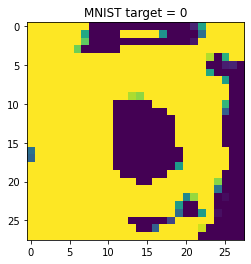

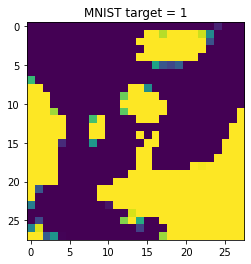

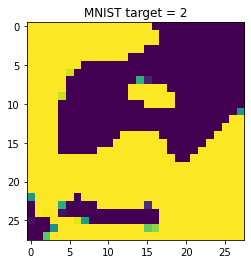

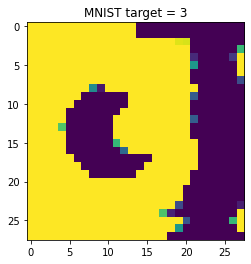

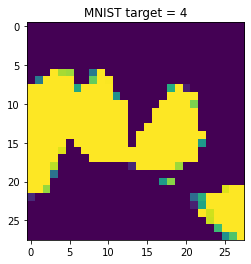

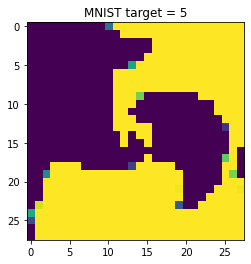

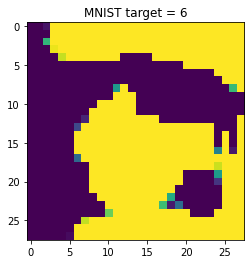

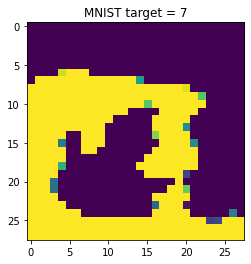

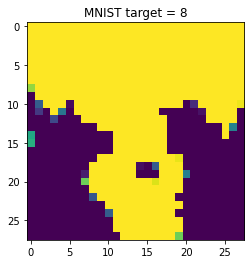

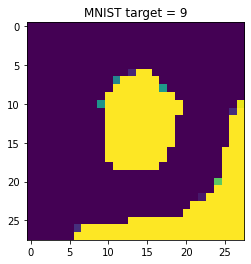

Predicted class for activation image_i [0 1 2 3 4 5 6 7 8 9] with prob [0.9999993, 0.9999504, 1.0, 1.0, 0.9999192, 1.0, 1.0, 1.0, 0.99999857, 1.0]


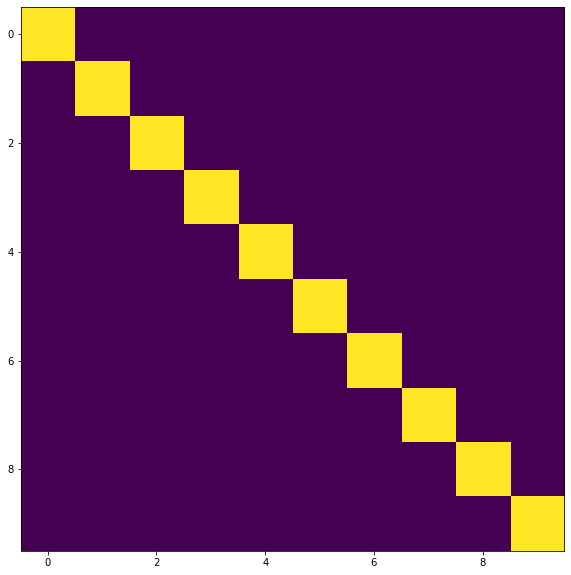

In [ ]:
# Activation Maximization parameters for CNN models (simple and regular models)
#activations = AM_MNIST(model, steps=500, learning_rate=.05, output_indexes=np.arange(10), jitter=.02, rotate=1, tv=.1, l2norm=.1, rho=.90) #np.arange(1)

# Activation Maximization parameters for fully connected model (I had to decrease learning rate bc the model was overshooting)
activations = AM_MNIST(model, steps=500, learning_rate=.03, output_indexes=np.arange(10), jitter=.02, rotate=1, tv=.1, l2norm=.1, rho=.90) #np.arange(1)
printActivationImages(activations)
pred = model(activations) # if activations normalized to input_range (0,1)
plt.figure(figsize=(50,10))
plt.imshow(pred)
print('Predicted class for activation image_i', np.argmax(pred, axis=1), 'with prob', [pred[item].numpy() for item in zip(np.arange(10),np.argmax(pred, axis=1))])